In [357]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.optimize import minimize
import networkx as nx
from queue import PriorityQueue
import matplotlib.pyplot as plt

In [358]:
class Packet:
    def __init__(self,index,time,src,dst,pre,cur,type):
        self.index = index
        self.t = time
        self.src = src
        self.dst = dst
        self.pre = pre
        self.cur = cur
        self.next = cur
        self.type = type 

In [359]:
class Link:
    def __init__(self,index,start,end,success_rate,type = 'generic link',mean_success_rate = 0.01,success_num = 0):
        self.index = index
        self.start = start
        self.end = end
        self._success_rate = success_rate
        self._success_num = success_num
        self.type = type
        self.mean_success_rate = mean_success_rate
        self.attempt_num = 0
        self.ETC = float('inf')
        self.path_cost = {}
        self.t = 1
        
    def __str__(self):
        return f"Link type: {self.type},  start: {self.node1},  end: {self.node2}"
    def Jt(self,end_node):
        if end_node in self.path_cost.keys():
            return self.path_cost[end_node]
        else:
            self.path_cost[end_node] = float('inf')
            return self.path_cost[end_node]
        
    
    def transmit(self,end_node,time):
        result = (np.random.random() <= self._success_rate)
        self.attempt_num += 1
        if result is True:
            self._success_num += 1
        self.mean_success_rate = self._success_num/self.attempt_num
        self.path_cost[end_node] = 1
        return result


In [360]:
class Node:
    def __init__(self,index):
        self.index = index
        self.dest = []
        self.neighbor = set()
        self.link = {}
        self.cost = {}
        self.t = 1
        
    def __str__(self):
        return f"Node {self.index}"
    def add_neighbor(self,link,neighbor_index):
        if neighbor_index in self.neighbor:
            self.link[neighbor_index] = link
        else:
            self.neighbor.add(neighbor_index)
            self.link[neighbor_index] = link
    def del_neighbor(self,neighbor_index):
        if neighbor_index in self.neighbor:
            self.neighbor.discard(neighbor_index)
            self.link.pop(neighbor_index)
            self.neighbor_cost.pop(neighbor_index)                   


In [361]:
def kl_divergence(p, q):
    if (p == 0 or q == 0 or q == 1): return 1
    return p * math.log(p / q) + (1 - p) * math.log((1 - p) / (1 - q))

In [362]:
class Policy:
    def __str__(self):
        return 'generic policy'
    def choose(self):
        return 0

class Totoro(Policy):
    def __init__(self,Graph,node_table,node,end_node,time,C):
        self.G = Graph
        self.node_table = node_table
        self.node = self.node_table[node] 
        self.end_node = self.node_table[end_node]
        self.t = time
        self.C = C
    def Update_ETC(self):
        for node,link in self.node.link.items():
            def constraint(u):
                if u == 1: return 1
                return (link.attempt_num * kl_divergence(link.mean_success_rate, u) - self.C * math.log(self.t)) <= 0
            def binary_search(asr, C, t, attempt, tol=1e-9):
                low, high = asr, 1
                best_u = asr
                
                while high - low > tol:
                    mid = (low + high) / 2
                    if constraint(mid):
                        best_u = mid
                        low = mid
                        #print(f"best value: {best_u}")
                    else:
                        high = mid
                return best_u
            best_u = binary_search(link.mean_success_rate,self.C,self.t,link.attempt_num)
            if best_u == 0: best_u += 1e-10
            link.ETC = 1/best_u
    def Jt(self, source, target):
        try:
            # Find the shortest path using Dijkstra's algorithm
            weight_func = lambda u, v, d: d['link'].ETC
            path = nx.dijkstra_path(self.G, source, target, weight=weight_func)
            # Calculate the total cost of the path
            cost = sum(self.G[u][v]['link'].ETC for u, v in zip(path[:-1], path[1:]))
            # for u, v in zip(path[:-1], path[1:]):
            #    print(f"link{self.G[u][v]['link'].index}, ETC{self.G[u][v]['link'].ETC}")
            return path, cost
        except nx.NetworkXNoPath:
            return None, float('inf')
    def choose(self):
        self.Update_ETC()
        cost = {}
        min_value = float('inf')
        min_index = []
        for node,link in self.node.link.items():
            cost[link.end] = link.ETC + self.Jt(link.end,self.end_node.index)[1]
            print(f"link{link.index}, ETC: {link.ETC}, Jt: {self.Jt(link.end,self.end_node.index)[1]}")
            if(cost[link.end] == min_value):
                min_index.append(link.index)
                min_value = cost[link.end]
            elif (cost[link.end] < min_value):
                min_index = [link.index]
                min_value = cost[link.end]
        print(min_index)
        final_index = random.choice(min_index)
        return final_index
            
        
        

0.5108256237659907
0.0
packet1, curID1
link1, ETC: 1.0000000009220094, Jt: inf
link2, ETC: 1.0000000009220094, Jt: inf
[1, 2]
link2 mean success rate:1.0 attempt num:1
packet2, curID1
link1, ETC: 1.0000000009220094, Jt: inf
link2, ETC: 1.0, Jt: inf
[1, 2]
packet2 transmit fail at link1
link1 mean success rate:0.0 attempt num:1
packet3, curID1
link1, ETC: 1.0000000009313226, Jt: inf
link2, ETC: 1.0, Jt: inf
[1, 2]
link1 mean success rate:0.5 attempt num:2
packet4, curID1
link1, ETC: 1.0000000009313226, Jt: inf
link2, ETC: 1.0, Jt: inf
[1, 2]
packet4 transmit fail at link1
link1 mean success rate:0.3333333333333333 attempt num:3
packet5, curID1
link1, ETC: 1.0000000006208818, Jt: inf
link2, ETC: 1.0, Jt: inf
[1, 2]
packet5 transmit fail at link2
link2 mean success rate:0.5 attempt num:2
packet6, curID1
link1, ETC: 1.0000000006208818, Jt: inf
link2, ETC: 1.0000000009313226, Jt: inf
[1, 2]
packet6 transmit fail at link1
link1 mean success rate:0.25 attempt num:4
packet7, curID1
link1, ETC:

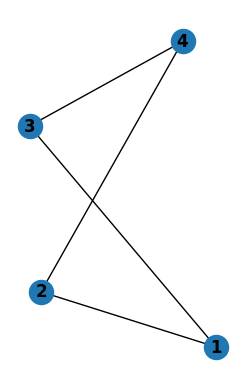

In [363]:
print(kl_divergence(0.5,0.9))
print(kl_divergence(0.5,0.5))
n = {}

l = {}
const = 20
delay = 100
total_attempt_num = 0
Graph = nx.Graph()
with open('input.in', 'r') as file:
    V, E = map(int, file.readline().strip().split(','))


    for _ in range(V):
        line = list(map(int, file.readline().strip().split()))
        index, dest_num = line[0], line[1]
        n[index] = Node(index)
        Graph.add_node(index,node = n[index])
        n[index].dest = line[2:]  # All destinations after dest_num

    # Read edge information
    for _ in range(E):
        index, start, end, success_rate = map(float, file.readline().strip().split())
        index, start, end = int(index), int(start), int(end)
        
        l[index] = Link(index, start, end, success_rate)
        Graph.add_edge(start, end,index=index, link = l[index])
        n[start].add_neighbor(l[index], n[end])
subax1 = plt.subplot(121)
nx.draw(Graph, with_labels=True, font_weight='bold')
p = {}
event = PriorityQueue()
for i in range(1,500):
    p[i] = Packet(i,i*5*delay,1,4,1,1,1)
    event.put((i*5,i))
while event.empty() is False:
    packet = p[event.get()[1]]
    n[packet.cur].t = packet.t
    print(f"packet{packet.index}, curID{packet.cur}")
    if (packet.cur == packet.dst):
        print(f"packet{packet.index} arrived")
        continue
    total_attempt_num += 1
    packet.t += delay
    best_link= Totoro(Graph,n,packet.cur, packet.dst, packet.t,const).choose()
    result = l[best_link].transmit(packet.dst,packet.t)
    if result is True:
        packet.next = l[best_link].end
        packet.cur = l[best_link].end
    else:
        print(f"packet{packet.index} transmit fail at link{best_link}")
        packet.next = packet.src
        packet.cur = packet.src
    event.put((packet.t,packet.index))
    print(f"link{best_link} mean success rate:{l[best_link].mean_success_rate} attempt num:{l[best_link].attempt_num}")
print("RESULT:")
for i in l.keys():
    print(f"Link{i}, attempt_num: {l[i].attempt_num}, mean_success_rate: {l[i].mean_success_rate}")
print(f"Total Attempt Num: {total_attempt_num}")
    

In [364]:
def constraint(u, asr, C, t, attempt):
    if u == 1: return 1
    return (attempt * kl_divergence(asr, u) - C * math.log(t)) <= 0
def binary_search(asr, C, t, attempt, tol=1e-9):
    low, high = asr, 1
    best_u = asr
    
    while high - low > tol:
        mid = (low + high) / 2
        if constraint(mid, asr, C, t, attempt):
            best_u = mid
            low = mid
            print(f"best value: {best_u}")
        else:
            high = mid
    return best_u
binary_search(0.5,1,100,50)

best value: 0.625
best value: 0.6875
best value: 0.703125
best value: 0.705078125
best value: 0.7050819396972656
best value: 0.705082893371582
best value: 0.7050830125808716
best value: 0.705083042383194
best value: 0.7050830461084843
best value: 0.7050830479711294
best value: 0.705083048902452


0.705083048902452